In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

sns.set_style("whitegrid")

In [58]:
df = pl.read_parquet("result.parquet").with_columns(((pl.col("best_bid_vol") - pl.col("best_ask_vol")) /
    (pl.col("best_bid_vol") + pl.col("best_ask_vol"))).alias("imbalance"))
df.shape


(84754875, 16)

In [59]:
N = 10000
df = df[:N]

In [67]:
phi = np.zeros(N)
eps = 1e10
n = df["type"].eq("Trade").sum()
ts = np.ones(n) * -float("inf")
xi = np.zeros(n)
j = 0

for i in range(N):
    type = df[i]["type"].item()
    side = df[i]["side"].item()
    t = df[i]["timestamp"].item()
    if type == "Trade":
        ts[j] = t
        xi[j] = side
        j += 1
    phi[i] = (xi / (t - ts + eps) ** 1.5).sum()

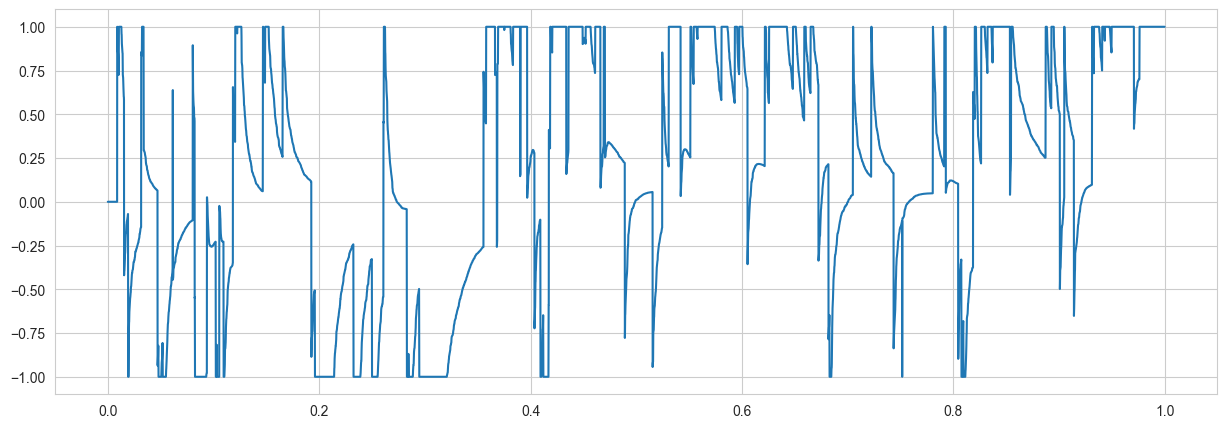

In [68]:
plt.figure(figsize=(15, 5))
A =1e15
plt.plot(np.arange(N)/ N, np.clip(A*phi, -1, 1))

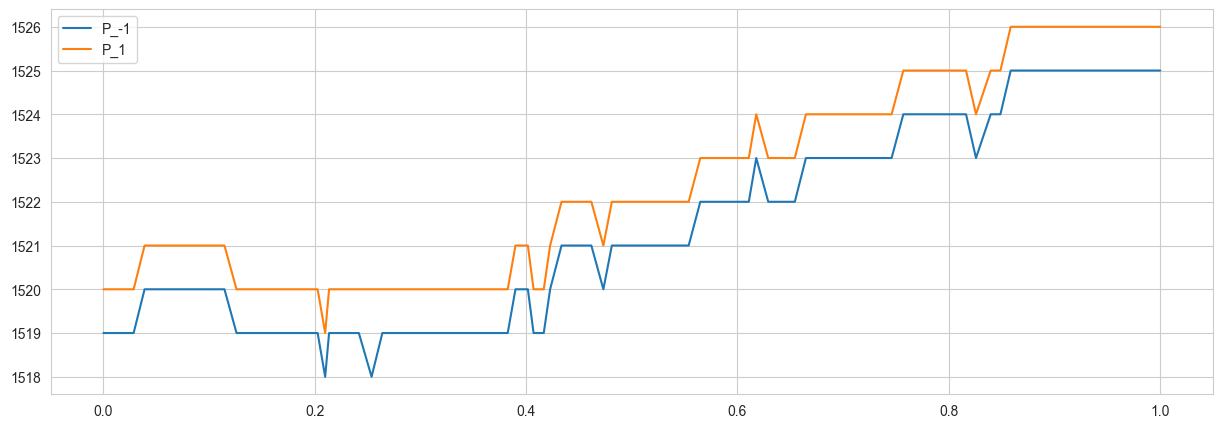

In [11]:
plt.figure(figsize=(15, 5))

df = df[::100]
plt.plot(df["timestamp"] / df["timestamp"].max(), df["best_bid_price"], label="P_-1")
plt.plot(df["timestamp"] / df["timestamp"].max(), df["best_ask_price"], label="P_1")

plt.legend()
plt.show()

In [12]:
df = pl.read_csv("data/AAL/inv_distributions_qmax30.csv")
for i in range(1, 6):
    p = df[f"bid_q{i}"] + df[f"ask_q{i}"]
    p = p / p.sum()
    df = df.with_columns(**{f"bid_q{i}" : p.to_numpy(), f"ask_q{i}" : p.to_numpy()})

In [13]:
plt.figure(figsize=(15, 5))

# df = df[::100]
plt.plot(df["timestamp"] / df["timestamp"].max(), -df["best_bid_vol"].cast(pl.Int64), label="Q_-1")
plt.plot(df["timestamp"] / df["timestamp"].max(), df["best_ask_vol"], label="Q_1")

plt.legend()
plt.show()

ColumnNotFoundError: "timestamp" not found

<Figure size 1500x500 with 0 Axes>

In [14]:
plt.figure(figsize=(15, 5))
# for alpha in [0.2, 0.4, 0.6, 0.8]:
for alpha in [.15]:
    plt.hist(df.filter(pl.col("type").eq("Trade"))["side"].ewm_mean(alpha=alpha), label=f"{alpha}", alpha=.8, bins=80)

plt.legend()
plt.show()


ColumnNotFoundError: unable to find column "type"; valid columns: ["value", "bid_q1", "bid_q2", "bid_q3", "bid_q4", "bid_q5", "ask_q1", "ask_q2", "ask_q3", "ask_q4", "ask_q5"]

<Figure size 1500x500 with 0 Axes>

In [15]:
from pathlib import Path

path = Path("/Users/saad.souilmi/dev_cpp/queue_reactive/data/results")
df = {}

for file in path.glob("*.csv"):
    alpha = float(file.as_posix().split("_")[-1][:3])
    df[alpha] = pl.read_csv(file)

df = dict(sorted(df.items(), key=lambda x: x[0]))

ValueError: could not convert string to float: 'imp'

In [ ]:
plt.figure(figsize=(15, 5))


for alpha in df:
    plt.plot(df[alpha]["timestamp"] / df[alpha]["timestamp"].max(), df[alpha]["avg_mid_price_change"], label=fr"$\alpha$ = {alpha}")

plt.xlabel("time")
plt.ylabel(r"$E[P_t - P_0]$")
plt.legend()
plt.show()

In [190]:
df = df[0.2]

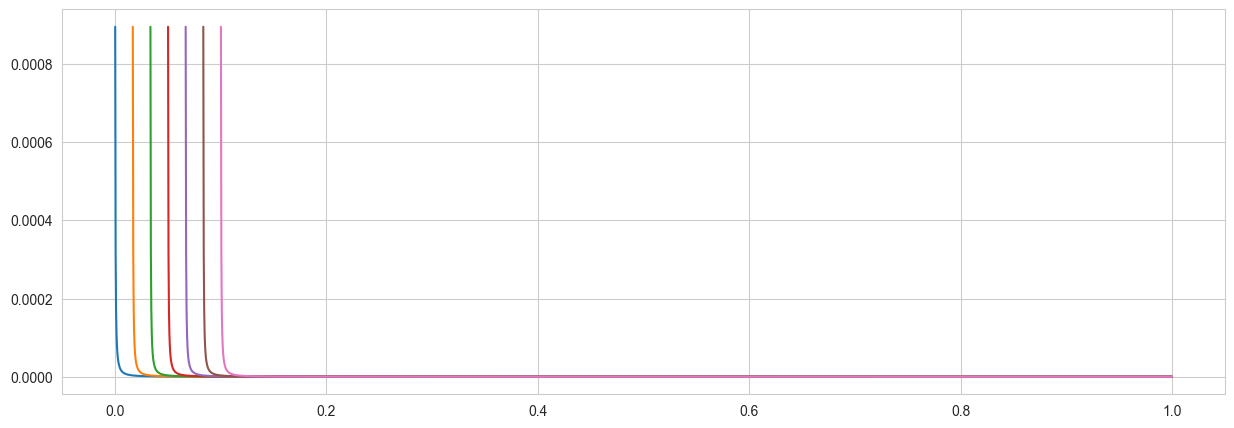

In [351]:
plt.figure(figsize=(15, 5))

ts = np.arange(7, dtype=int) * int(1e9) * 20
eps = 1e-3

for t in ts:
    x = np.maximum((df["timestamp"] - t).to_numpy(), 0)
    A = 1e10
    x = A / (x + eps)**(3/2)

    mask = (df["timestamp"] > t).to_numpy()

    plt.plot((df["timestamp"] / df["timestamp"].max()).filter(mask), x[mask])

plt.show()


In [119]:
def plot_impact(df, include_trade_probs=False, warmup_ns = int(1e9) * 120):
    if include_trade_probs:
        fig = plt.figure(figsize=(15, 12))
        gs = fig.add_gridspec(3, 2)
        ax1 = fig.add_subplot(gs[0, :])
        ax2 = fig.add_subplot(gs[1, :])
        ax3 = fig.add_subplot(gs[2, 0])
        ax4 = fig.add_subplot(gs[2, 1], sharey=ax3)
    else:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))

    max_ts = df["timestamp"].max()
    warmup_x = warmup_ns / max_ts
    x = df["timestamp"] / max_ts
    
    # Row 1: avg_mid_price_change
    ax1.axvspan(0, warmup_x, color="tab:blue", alpha=0.2)
    ax1.plot(x, df["avg_mid_price_change"], linewidth=2)
    ax1.set_xlabel("time")
    ax1.set_ylabel(r"$E[P_t - P_0]$")
    
    # Row 2: avg_bias
    ax2.axvspan(0, warmup_x, color="tab:blue", alpha=0.2)
    ax2.plot(x, df["avg_bias"], linewidth=2)
    ax2.set_xlabel("time")
    ax2.set_ylabel(r"$\phi(t)$")
    
    if include_trade_probs:
        # Row 3 left: Bid trade probabilities
        ax3.axvspan(0, warmup_x, color="tab:blue", alpha=0.2)
        for i in range(10):
            ax3.plot(x, df[f"bin_{i}_bid_trade_prob"], linewidth=2, label=f"bin {i}")
        ax3.set_xlabel("time")
        ax3.set_ylabel("bid trade probability")
        ax3.legend()
        ax3.set_title("Bid Trade Probabilities")
        
        # Row 3 right: Ask trade probabilities
        ax4.axvspan(0, warmup_x, color="tab:blue", alpha=0.2)
        for i in range(10):
            ax4.plot(x, df[f"bin_{i}_ask_trade_prob"], linewidth=2, label=f"bin {i}")
        ax4.set_xlabel("time")
        ax4.set_ylabel("ask trade probability")
        ax4.legend()
        ax4.set_title("Ask Trade Probabilities")
    
    plt.tight_layout()
    plt.show()

In [ ]:
df1 = pl.read_csv("/Users/saad.souilmi/dev_cpp/queue_reactive/data/results/no_impact_size_1.csv", infer_schema_length=10000)
df3 = pl.read_csv("/Users/saad.souilmi/dev_cpp/queue_reactive/data/results/no_impact_size_3.csv", infer_schema_length=10000)
df5 = pl.read_csv("/Users/saad.souilmi/dev_cpp/queue_reactive/data/results/no_impact_size_5.csv", infer_schema_length=10000)

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

warmup_ns = int(1e9) * 120

for ax, (df, size) in zip(axes, [(df1, 1), (df3, 3), (df5, 5)]):
    max_ts = df["timestamp"].max()
    warmup_x = warmup_ns / max_ts
    ax.axvspan(0, warmup_x, color="tab:blue", alpha=0.2)
    ax.plot(df["timestamp"] / max_ts, df["avg_mid_price_change"], linewidth=2)
    ax.set_xlabel("time")
    ax.set_ylabel(r"$E[P_t - P_0]$")
    ax.set_title(f"size = {size}")

plt.tight_layout()
plt.show()

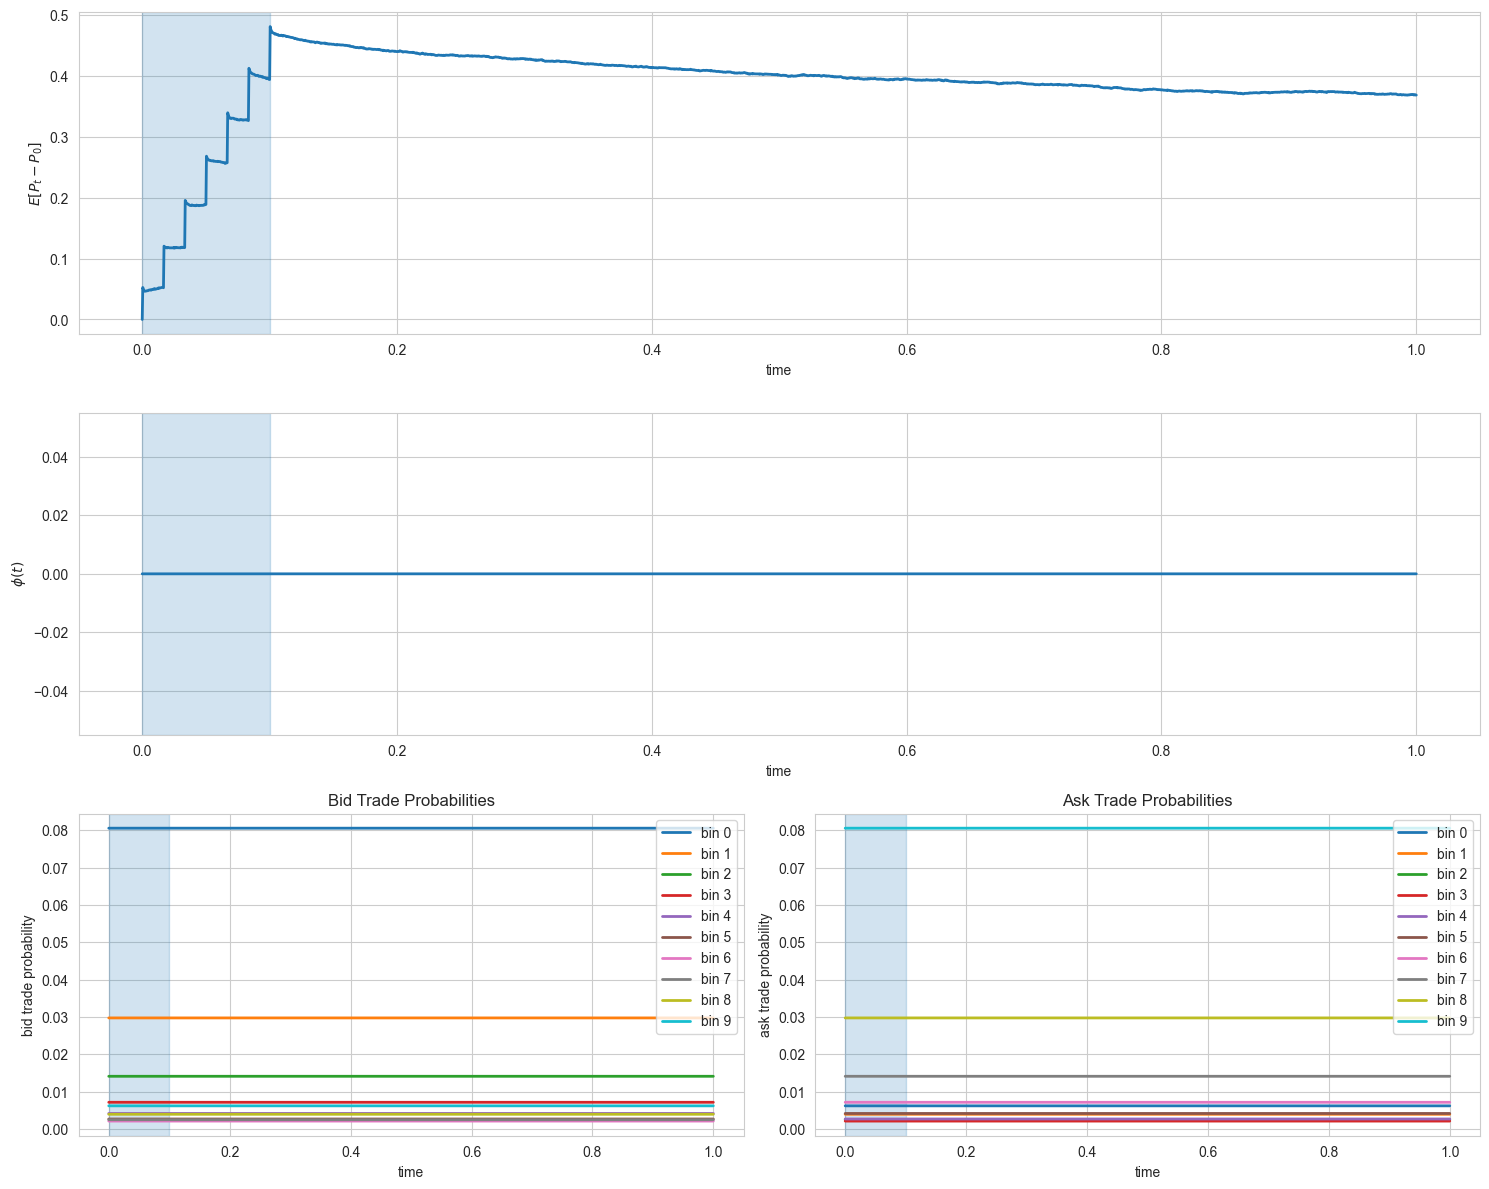

In [117]:
df = pl.read_csv("/Users/saad.souilmi/dev_cpp/queue_reactive/data/results/no_impact.csv", infer_schema_length=10000)
plot_impact(df, include_trade_probs=True)

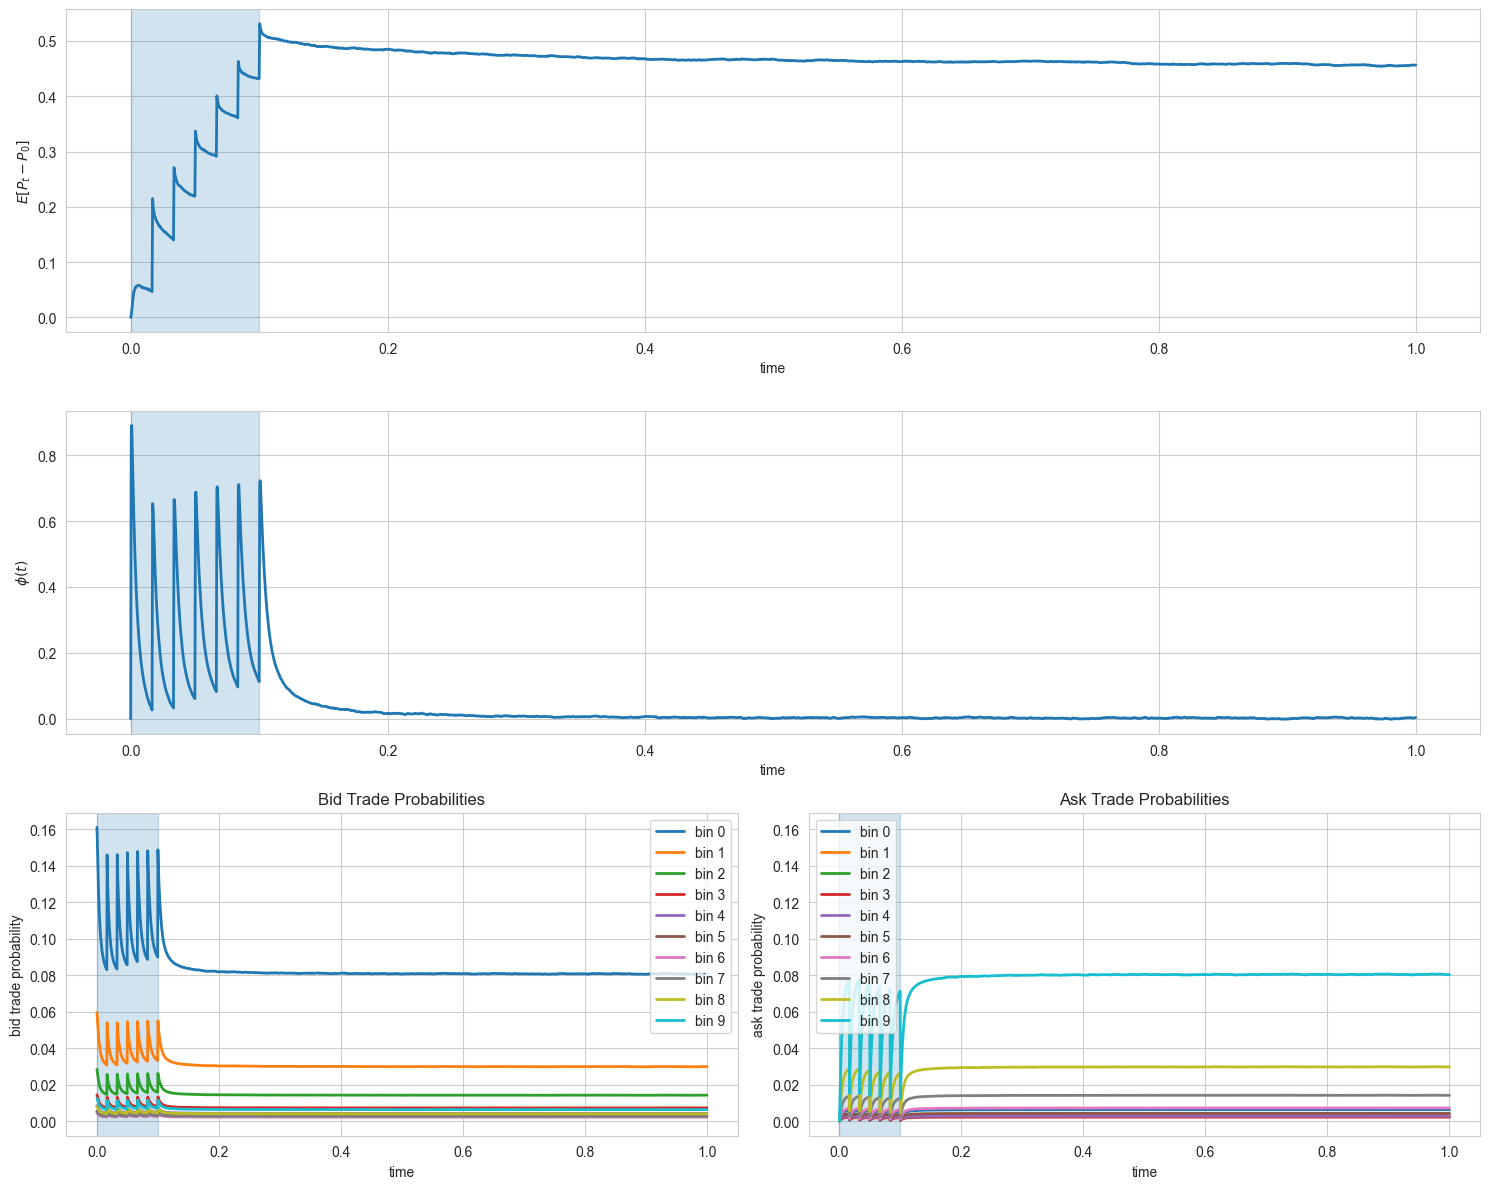

In [116]:
df = pl.read_csv("/Users/saad.souilmi/dev_cpp/queue_reactive/data/results/power_law_impact_alpha_1.5.csv", infer_schema_length=10000)
plot_impact(df, include_trade_probs=True)

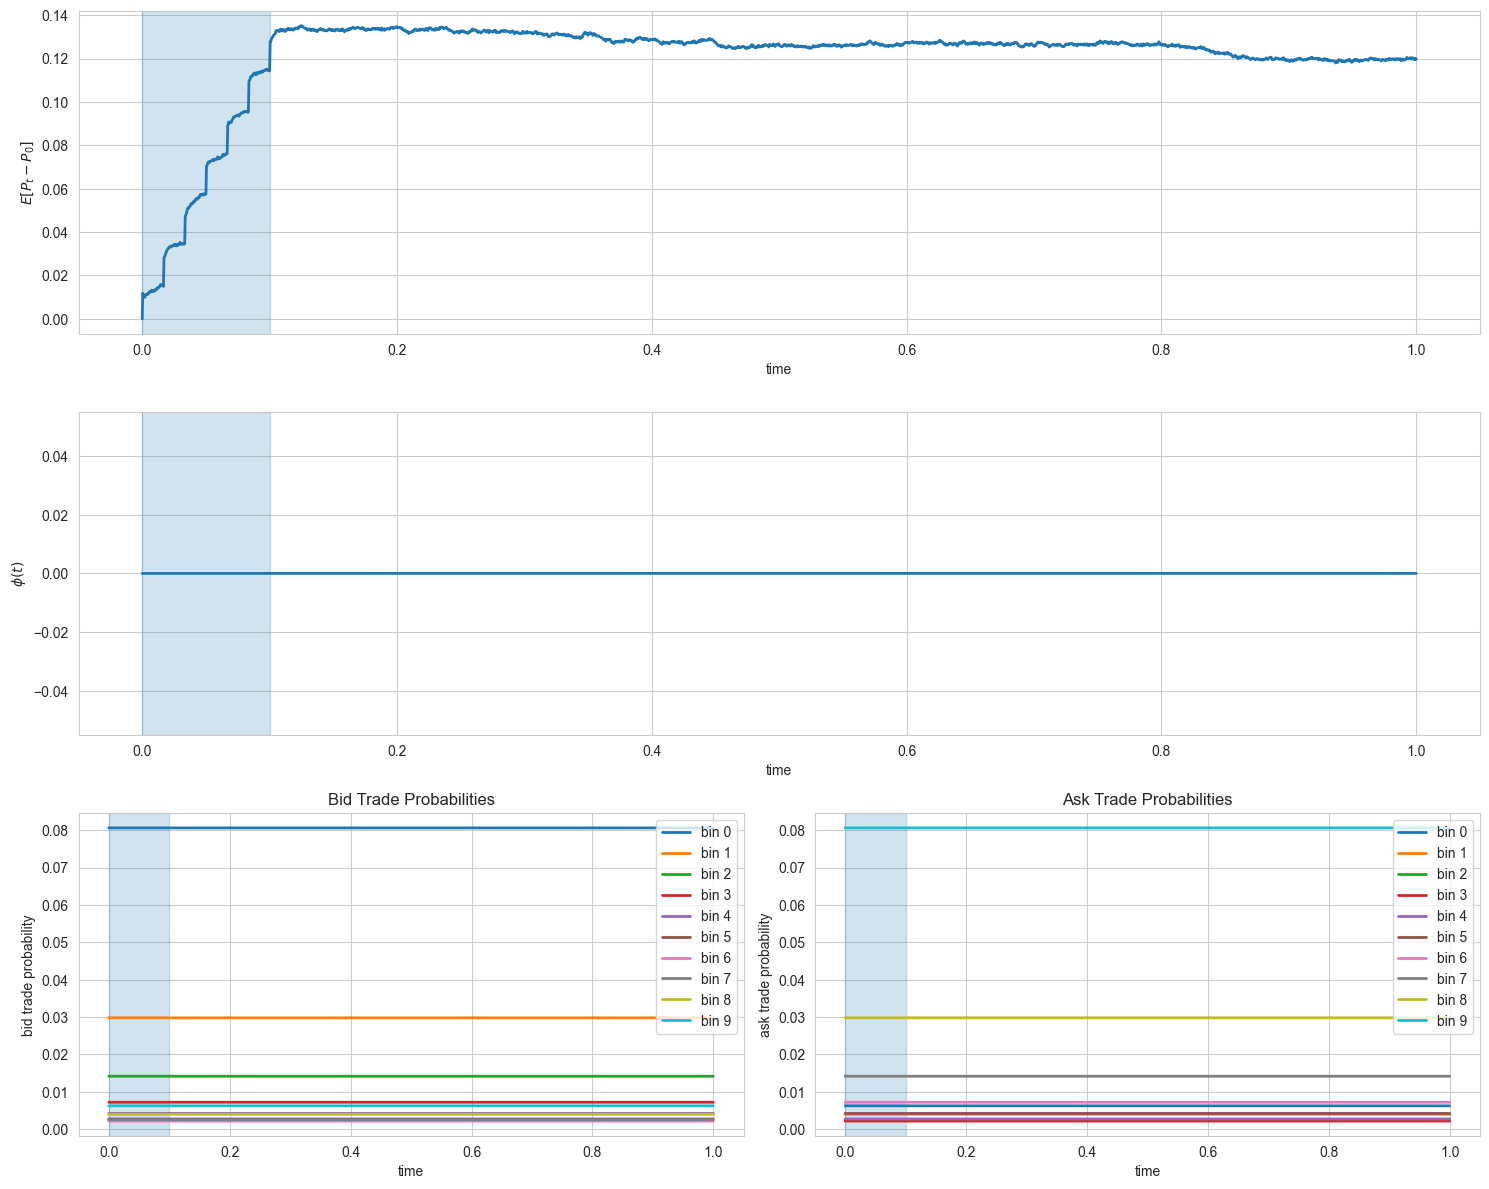

In [133]:
df = pl.read_csv("/Users/saad.souilmi/dev_cpp/queue_reactive/data/results/no_impact_size_1.csv", infer_schema_length=10000)
plot_impact(df, include_trade_probs=True)

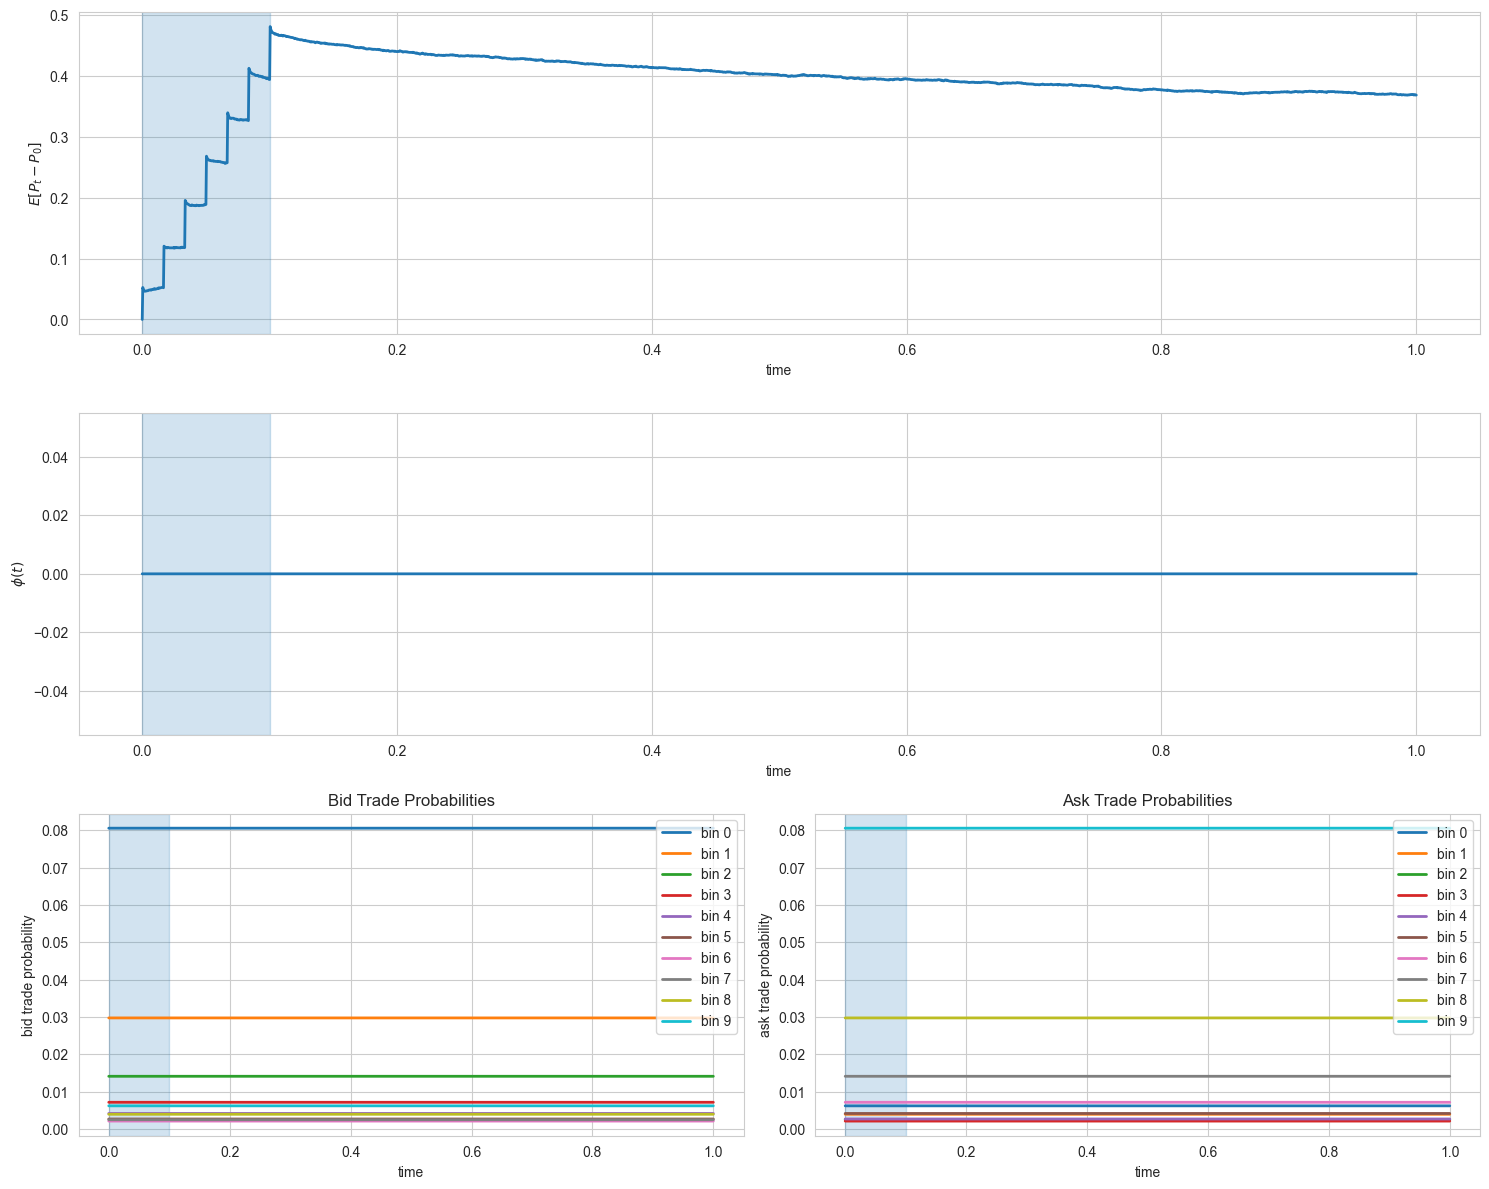

In [135]:
df = pl.read_csv("/Users/saad.souilmi/dev_cpp/queue_reactive/data/results/no_impact_size_3.csv", infer_schema_length=10000)
plot_impact(df, include_trade_probs=True)

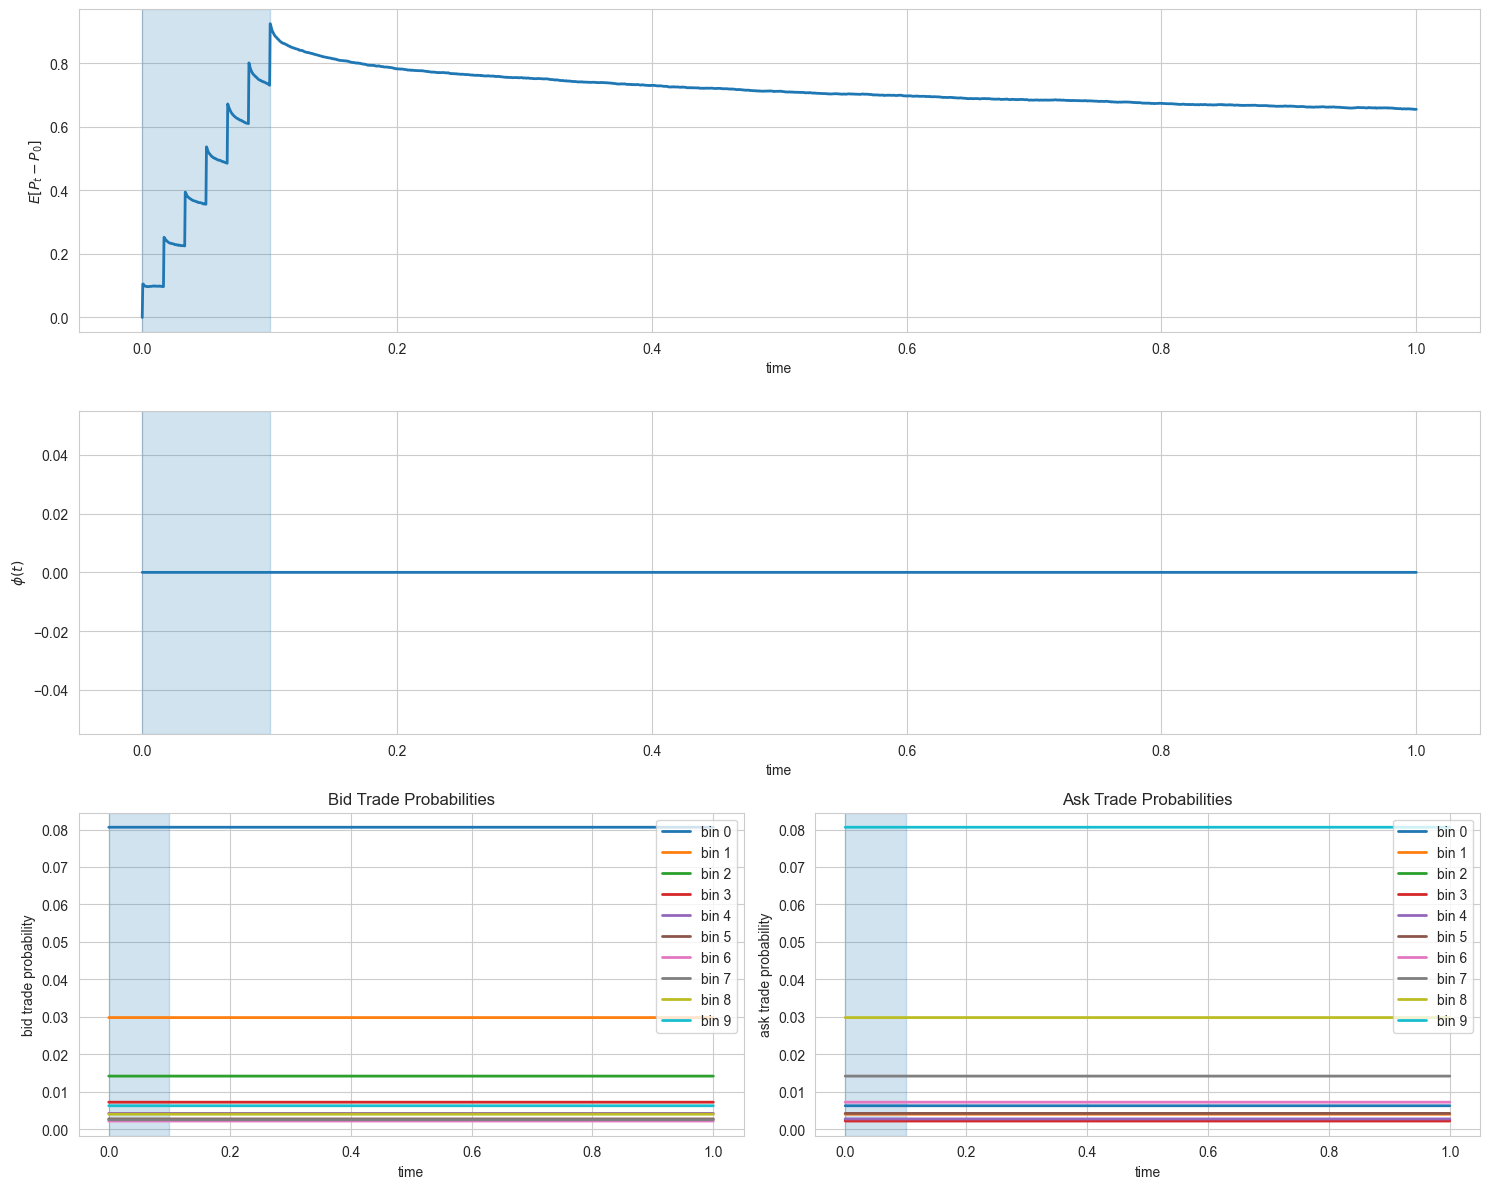

In [136]:
df = pl.read_csv("/Users/saad.souilmi/dev_cpp/queue_reactive/data/results/no_impact_size_5.csv", infer_schema_length=10000)
plot_impact(df, include_trade_probs=True)

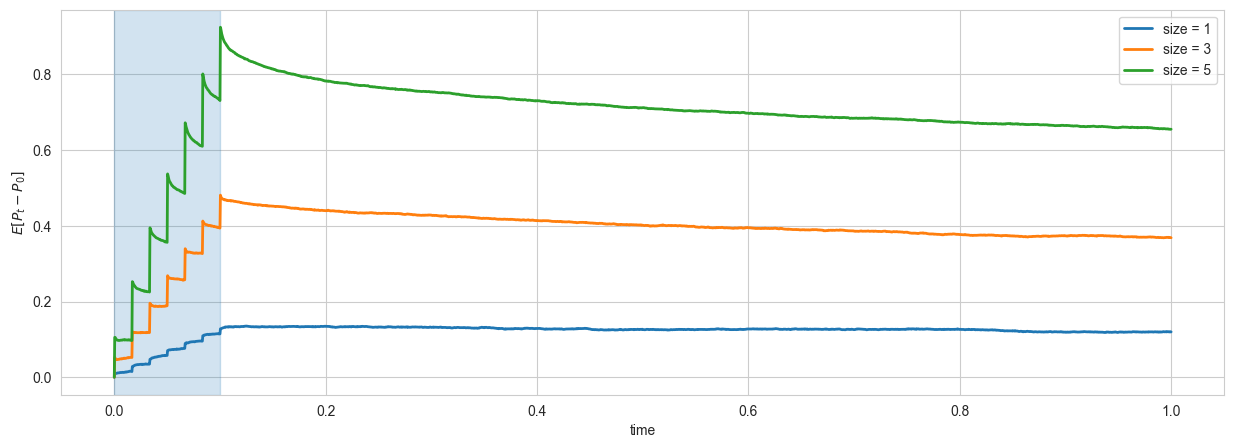

In [131]:
df1 = pl.read_csv("/Users/saad.souilmi/dev_cpp/queue_reactive/data/results/no_impact_size_1.csv", infer_schema_length=10000)
df3 = pl.read_csv("/Users/saad.souilmi/dev_cpp/queue_reactive/data/results/no_impact_size_3.csv", infer_schema_length=10000)
df5 = pl.read_csv("/Users/saad.souilmi/dev_cpp/queue_reactive/data/results/no_impact_size_5.csv", infer_schema_length=10000)

plt.figure(figsize=(15, 5))

warmup_ns = int(1e9) * 120
max_ts = df1["timestamp"].max()
warmup_x = warmup_ns / max_ts
plt.axvspan(0, warmup_x, color="tab:blue", alpha=0.2)

plt.plot(df1["timestamp"] / df1["timestamp"].max(), df1["avg_mid_price_change"], linewidth=2, label="size = 1")
plt.plot(df3["timestamp"] / df3["timestamp"].max(), df3["avg_mid_price_change"], linewidth=2, label="size = 3")
plt.plot(df5["timestamp"] / df5["timestamp"].max(), df5["avg_mid_price_change"], linewidth=2, label="size = 5")

plt.legend()
plt.xlabel("time")
plt.ylabel(r"$E[P_t - P_0]$")
plt.show()

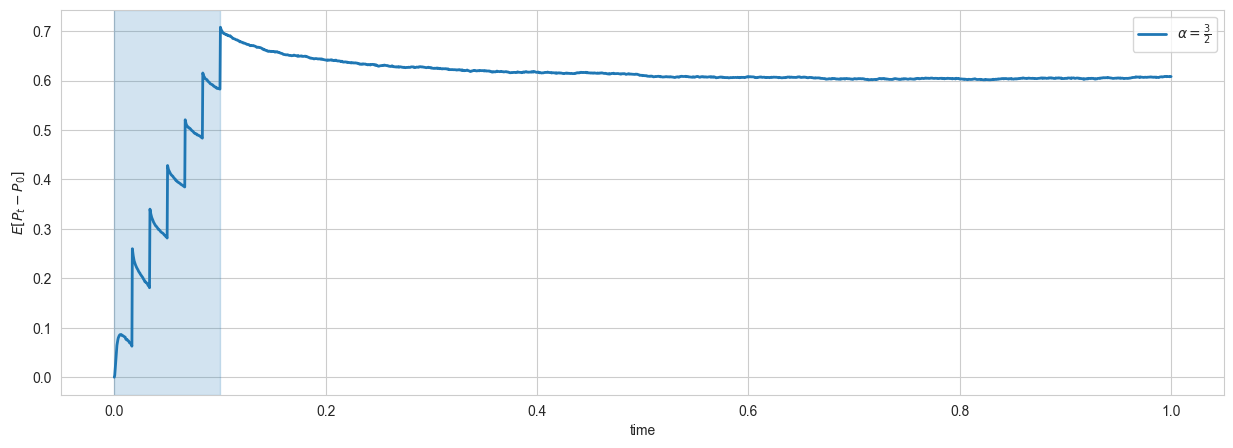

In [480]:
plt.figure(figsize=(15, 5))

# df = pl.read_csv("/Users/saad.souilmi/dev_cpp/queue_reactive/data/results/avg_mid_price_alpha_1.500000.csv")
max_ts = df["timestamp"].max()
warmup_x = warmup_ns / max_ts
plt.axvspan(0, warmup_x, color="tab:blue", alpha=0.2)

plt.plot(df["timestamp"] / df["timestamp"].max(), df["avg_mid_price_change"], linewidth = 2, label=r"$\alpha = \frac{3}{2}$")

# df = pl.read_csv("/Users/saad.souilmi/dev_cpp/queue_reactive/data/results/avg_mid_price_alpha_0.500000.csv")
# plt.plot(df["timestamp"] / df["timestamp"].max(), df["avg_mid_price_change"], linewidth = 2, label=r"$\alpha = \frac{1}{2}$")

plt.legend()
plt.xlabel("time")
plt.ylabel(r"$E[P_t - P_0]$")
plt.show()

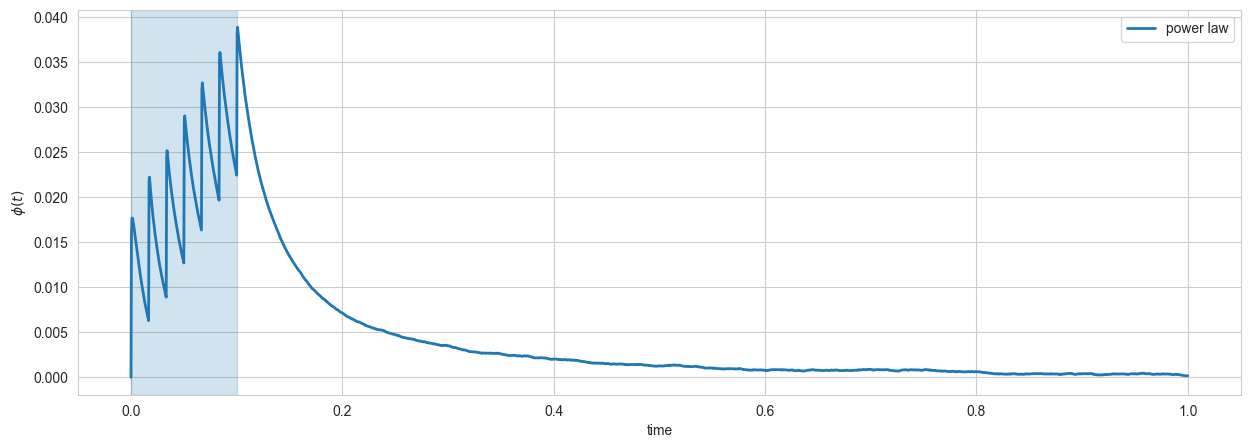

In [477]:
plt.figure(figsize=(15, 5))

df = pl.read_csv("/Users/saad.souilmi/dev_cpp/queue_reactive/data/results/avg_mid_price_alpha_1.500000.csv")

max_ts = df["timestamp"].max()
warmup_x = warmup_ns / max_ts
plt.axvspan(0, warmup_x, color="tab:blue", alpha=0.2)
# df = pl.read_csv("/Users/saad.souilmi/dev_cpp/queue_reactive/data/results/avg_mid_price_alpha_0.990000.csv")

plt.plot(df["timestamp"] / df["timestamp"].max(), df["avg_bias"], linewidth = 2, label="power law")

# df = pl.read_csv("/Users/saad.souilmi/dev_cpp/queue_reactive/data/results/avg_mid_price_alpha_0.200000.csv")
# plt.plot(df["timestamp"] / df["timestamp"].max(), df["avg_mid_price_change"], linewidth = 2, label=r"$\alpha$ = 0.2")

plt.legend()
plt.xlabel("time")
plt.ylabel(r"$\phi(t)$")
plt.show()

In [103]:
f = Path("/Users/saad.souilmi/dev_python/aqr/data/QR/v1/raw/AAL/xnas-itch")
df = pl.read_parquet(list(f.glob("*.parquet")))

In [92]:
mes = df.group_by("event_queue_nbr").agg(pl.col("event_size").median()).filter(pl.col("event_queue_nbr").ne(0))

In [97]:
mes = mes.with_columns(pl.col("event_size").sum().over(pl.col("event_queue_nbr").abs()) / 2)

In [105]:
mes_dict = (
    mes.with_columns(pl.col("event_queue_nbr").abs().alias("abs_queue"))
    .group_by("abs_queue")
    .agg(pl.col("event_size").mean())
    .filter(pl.col("abs_queue").is_between(1, 4))
    .to_dict()
)
mes_dict = dict(zip(mes_dict["abs_queue"], mes_dict["event_size"]))

df = df.with_columns([
    (pl.col(f"Q_{i}") / mes_dict[abs(i)]).ceil().cast(pl.Int64).alias(f"Q_{i}")
    for i in [-4, -3, -2, -1, 1, 2, 3, 4]
])

In [109]:
cols = [f"Q_{i}" for i in [-4, -3, -2, -1, 1, 2, 3, 4]] + [f"P_{i}" for i in [-4, -3, -2, -1, 1, 2, 3, 4]]
df_sample = df.sample(n=10_000).select(cols)
df_sample.write_csv("data/AAL/sample_lob_10k.csv")

In [106]:
df

symbol,date,ts_event,event,event_size,price,event_side,event_queue_nbr,event_queue_size,best_bid_nbr,Q_-10,Q_-9,Q_-8,Q_-7,Q_-6,Q_-5,Q_-4,Q_-3,Q_-2,Q_-1,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8,Q_9,Q_10,best_ask_nbr,P_-10,P_-9,P_-8,P_-7,P_-6,P_-5,P_-4,P_-3,P_-2,P_-1,P_0,P_1,P_2,P_3,P_4,P_5,P_6,P_7,P_8,P_9,P_10,spread,imbalance
str,date,"datetime[ns, US/Eastern]",str,u32,i32,str,i32,i64,i32,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i32,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,f64
"""AAL""",2024-05-29,2024-05-29 10:00:00.102501978 EDT,"""Add""",700,1137,"""B""",-1,2165,-1,2961,1620,11685,823,1099,4220,94,38,13,5,0,26,5,10,30,2333,1400,1400,1900,1000,1700,1,1128,1129,1130,1131,1132,1133,1134,1135,1136,1137,null,1138,1139,1140,1141,1142,1143,1144,1145,1146,1147,1,-0.709279
"""AAL""",2024-05-29,2024-05-29 10:00:00.257111515 EDT,"""Add""",1500,1130,"""B""",-8,11685,-1,2961,1620,11685,823,1099,4220,94,38,13,6,0,26,5,10,30,2333,1400,1400,1900,1000,1700,1,1128,1129,1130,1131,1132,1133,1134,1135,1136,1137,null,1138,1139,1140,1141,1142,1143,1144,1145,1146,1147,1,-0.632551
"""AAL""",2024-05-29,2024-05-29 10:00:00.435382134 EDT,"""Add""",829,1138,"""A""",1,12729,-1,2961,1620,13185,823,1099,4220,94,38,13,6,0,26,5,10,30,2333,1400,1400,1900,1000,1700,1,1128,1129,1130,1131,1132,1133,1134,1135,1136,1137,null,1138,1139,1140,1141,1142,1143,1144,1145,1146,1147,1,-0.632551
"""AAL""",2024-05-29,2024-05-29 10:00:00.435425208 EDT,"""Add""",500,1138,"""A""",1,13558,-1,2961,1620,13185,823,1099,4220,94,38,13,6,0,28,5,10,30,2333,1400,1400,1900,1000,1700,1,1128,1129,1130,1131,1132,1133,1134,1135,1136,1137,null,1138,1139,1140,1141,1142,1143,1144,1145,1146,1147,1,-0.651099
"""AAL""",2024-05-29,2024-05-29 10:00:00.435606643 EDT,"""Add""",2000,1137,"""B""",-1,2865,-1,2961,1620,13185,823,1099,4220,94,38,13,6,0,29,5,10,30,2333,1400,1400,1900,1000,1700,1,1128,1129,1130,1131,1132,1133,1134,1135,1136,1137,null,1138,1139,1140,1141,1142,1143,1144,1145,1146,1147,1,-0.661408
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""AAL""",2024-01-04,2024-01-04 15:29:57.966681180 EST,"""Can""",500,1311,"""B""",-1,34401,-1,1060,4506,4101,10152,13602,19391,478,150,116,69,0,33,52,88,158,20033,17222,15802,11101,7470,3801,1,1302,1303,1304,1305,1306,1307,1308,1309,1310,1311,null,1312,1313,1314,1315,1316,1317,1318,1319,1320,1321,1,0.362173
"""AAL""",2024-01-04,2024-01-04 15:29:57.966715157 EST,"""Can""",800,1311,"""B""",-1,33901,-1,1060,4506,4101,10152,13602,19391,478,150,116,68,0,33,52,88,158,20033,17222,15802,11101,7470,3801,1,1302,1303,1304,1305,1306,1307,1308,1309,1310,1311,null,1312,1313,1314,1315,1316,1317,1318,1319,1320,1321,1,0.355796
"""AAL""",2024-01-04,2024-01-04 15:29:58.463663323 EST,"""Add""",100,1311,"""B""",-1,33101,-1,1060,4506,4101,10152,13602,19391,478,150,116,67,0,33,52,88,158,20033,17222,15802,11101,7470,3801,1,1302,1303,1304,1305,1306,1307,1308,1309,1310,1311,null,1312,1313,1314,1315,1316,1317,1318,1319,1320,1321,1,0.345323


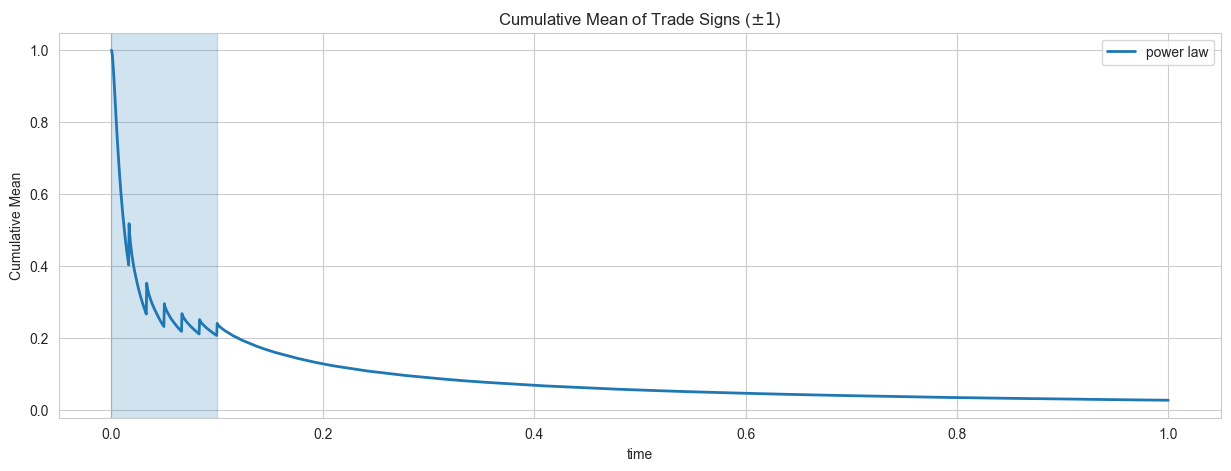

In [476]:
plt.figure(figsize=(15, 5))

max_ts = df["timestamp"].max()
warmup_x = warmup_ns / max_ts
plt.axvspan(0, warmup_x, color="tab:blue", alpha=0.2)
# df = pl.read_csv("/Users/saad.souilmi/dev_cpp/queue_reactive/data/results/avg_mid_price_alpha_0.990000.csv")

plt.plot(df["timestamp"] / df["timestamp"].max(), df["avg_trade_sign_mean"], linewidth = 2, label="power law")

# df = pl.read_csv("/Users/saad.souilmi/dev_cpp/queue_reactive/data/results/avg_mid_price_alpha_0.200000.csv")
# plt.plot(df["timestamp"] / df["timestamp"].max(), df["avg_mid_price_change"], linewidth = 2, label=r"$\alpha$ = 0.2")

plt.legend()
plt.xlabel("time")
plt.ylabel("Cumulative Mean")
plt.title(r"Cumulative Mean of Trade Signs ($\pm 1$)")
plt.show()

In [362]:
path = Path("/Users/saad.souilmi/dev_python/aqr/data/QR/v1/raw/AAL/xnas-itch")

df = pl.read_parquet(list(path.glob("*.parquet")))

In [365]:
df.group_by("event_queue_nbr").agg(pl.col("event_size").median()).filter(pl.col("event_queue_nbr").is_between(-4, 4)).sort("event_queue_nbr")


event_queue_nbr,event_size
i32,f64
-4,100.0
-3,100.0
-2,257.0
-1,500.0
0,353.0
1,500.0
2,400.0
3,300.0
4,100.0


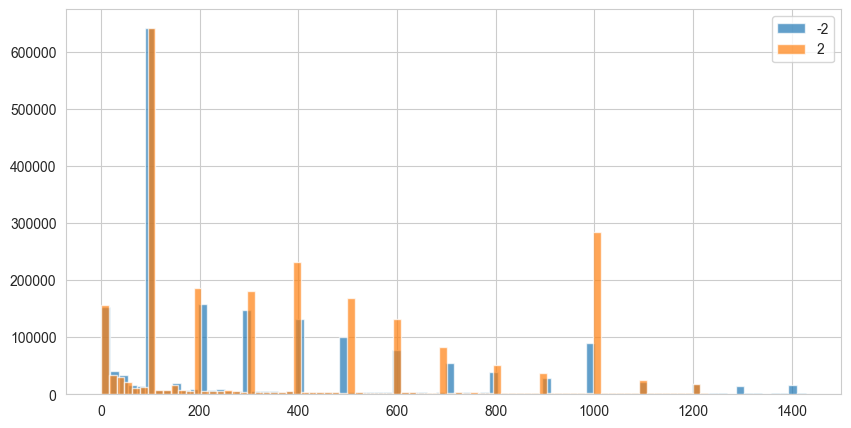

In [373]:
plt.figure(figsize=(10, 5))

q = df.filter(pl.col("event_queue_nbr").eq(-2))
q = q.filter(pl.col("event_size").le(pl.col("event_size").quantile(.9)))
plt.hist(q["event_size"], label="-2", bins=80, alpha=.7)

q = df.filter(pl.col("event_queue_nbr").eq(2))
q = q.filter(pl.col("event_size").le(pl.col("event_size").quantile(.9)))
plt.hist(q["event_size"], label="2", bins=80, alpha=.7)

plt.legend()
plt.show()

In [30]:
df = pl.read_csv("data/AAL/event_probabilities.csv")

In [34]:
def plot_probabilities(
        df,
        spread: int = 1,
        figsize: tuple[int, int] = (15, 5),
    ) -> None:
        """Plot event probabilities against imbalance.

        Creates three sets of plots showing event probabilities:
        1. At empty queues (if spread > 1)
        2. At best limits
        3. At second limits

        Args:
            ticker: Instrument symbol
            start_date: Start date in YYYY-MM-DD format
            end_date: End date in YYYY-MM-DD format
            spread: Spread level to analyze, by default 1
            figsize: Figure size (width, height), by default (15, 5)
        """
        probabilities = df
        if spread > 1:
            fig_empty_queues, axs_empty_queues = plt.subplots(1, 2, figsize=figsize)
            axs_empty_queues = axs_empty_queues.ravel()
            df_ = probabilities.filter(
                pl.col("spread").eq(spread)
                & pl.col("probability").gt(0)
                & pl.col("event").ne("F")
                & pl.col("event_queue_nbr").abs().lt((spread - 1) // 2 + 1)
            )

            for ax, ((side,), data) in zip(axs_empty_queues, df_.group_by("event")):
                data = data.sort(by=["event_queue_nbr", "imbalance_left"])
                for (queue,), data_ in data.group_by("event_queue_nbr"):
                    ax.plot(
                        data_["imbalance_left"],
                        data_["probability"],
                        label=rf"$Q_{queue}$",
                        marker="o",
                        ms=3,
                        mec="k",
                    )

                ax.set_title(side)
                ax.set_xlabel("imbalance")
                ax.set_ylabel("probability")
                ax.legend()

            fig_empty_queues.suptitle(
                f"{ticker} Event probabilities at empty queues (spread = {spread})"
            )
            fig_empty_queues.tight_layout()

        fig_first_limits, axs_first_limits = plt.subplots(1, 2, figsize=figsize)
        axs_first_limits = axs_first_limits.ravel()

        df_ = probabilities.filter(
            pl.col("spread").eq(spread)
            & pl.col("probability").gt(0)
            & pl.col("event").ne("F")
            & pl.col("event_queue_nbr").abs().eq((spread - 1) // 2 + 1)
        )

        for ax, ((side,), data) in zip(axs_first_limits, df_.sort(by="event_side", descending=True).group_by("event_side")):
            data = data.sort(by=["event", "imbalance_left"])
            for (event,), data_ in data.group_by("event"):
                ax.plot(
                    data_["imbalance_left"],
                    data_["probability"],
                    label=event,
                    marker="o",
                    ms=3,
                    mec="k",
                )
            ax.set_title({"A": "Ask", "B": "Bid"}[side])
            ax.set_xlabel("imbalance")
            ax.set_ylabel("probability")
            ax.legend()

        fig_first_limits.suptitle(
            f"{ticker} Event probabilities at best limit (spread = {spread})"
        )
        fig_first_limits.tight_layout()

        df_ = probabilities.filter(
            pl.col("spread").eq(spread)
            & pl.col("probability").gt(0)
            & pl.col("event").ne("F")
            & pl.col("event_queue_nbr").abs().eq((spread - 1) // 2 + 2)
        )

        fig_second_limits, axs_second_limits = plt.subplots(1, 2, figsize=(15, 5))
        axs_second_limits = axs_second_limits.ravel()

        for ax, ((side,), data) in zip(axs_second_limits, df_.sort(by="event_side", descending=True).group_by("event_side")):
            data = data.sort(by=["event", "imbalance_left"])
            for (event,), data_ in data.group_by("event"):
                ax.plot(
                    data_["imbalance_left"],
                    data_["probability"],
                    label=event,
                    marker="o",
                    ms=3,
                    mec="k",
                )
            ax.set_title({"A": "Ask", "B": "Bid"}[side])
            ax.set_xlabel("imbalance")
            ax.set_ylabel("probability")
            ax.legend()

        fig_second_limits.suptitle(
            f"{ticker} Event probabilities at second limit (spread = {spread})"
        )
        fig_second_limits.tight_layout()

        plt.show()
        plt.close()


In [37]:
df

imbalance_left,spread,event,event_side,event_queue_nbr,probability,imbalance_bin
f64,i64,str,str,i64,f64,i64
-0.2,1,"""Trd""","""B""",-1,0.004195,5
0.0,1,"""Can""","""B""",-1,0.215279,6
-0.6,1,"""Can""","""B""",-2,0.04468,3
0.6,1,"""Can""","""B""",-2,0.027337,9
-0.2,1,"""Add""","""A""",1,0.208094,5
…,…,…,…,…,…,…
0.6,1,"""Trd""","""B""",-1,0.00398,9
-0.4,1,"""Add""","""B""",-1,0.189505,4
-0.6,1,"""Add""","""A""",2,0.032481,3


NameError: name 'ticker' is not defined

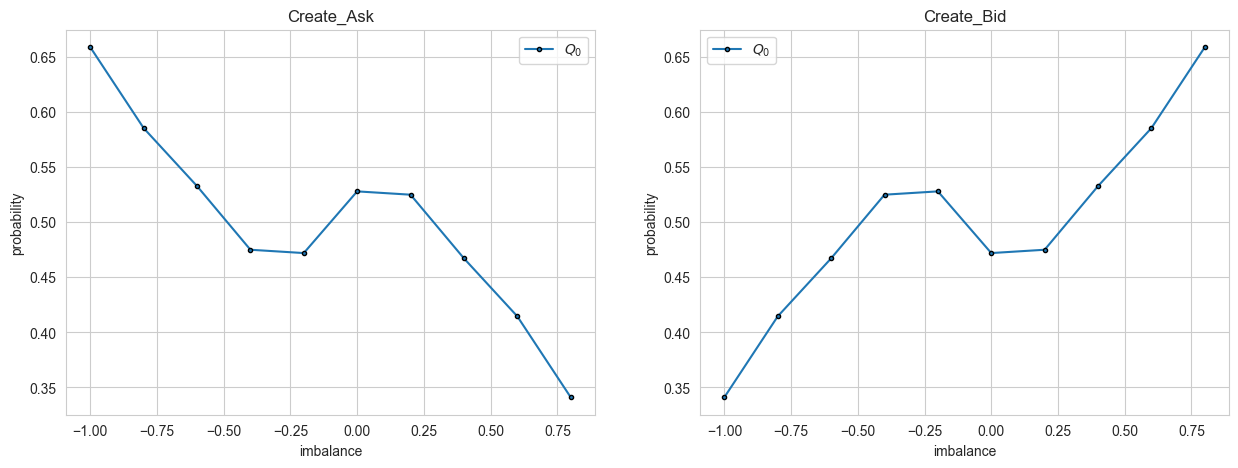

In [36]:
plot_probabilities(df, spread=2)